# NYC Metro Database Forecast

## Table of Contents:
* [1. Imports](#imports)
* [2. Forecasting](#forecasting)
    * [2.1. Prophet](#prophet)
        * [2.1.1. Total traffic forecast](#prophet-1)
        * [2.1.2. Forecast by stations and lines](#prophet-2)
    * [2.2. XGBoost](#xgboost)
        * [2.2.1. Total traffic forecast](#xgboost-1)
        * [2.2.2. Forecast by stations and lines](#xgboost-2)
* [3. Summary of results](#summary)

## Abstract

In this notebook I have tried two different approaches to forecast the NYC Metro Database, Prophet and XGBoost Regressor.

The **Prophet** is a procedure for forecasting time series data based on an additive/multiplicative model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works really well with time series that have strong seasonal effects. Considering the previous investigation of our data, the Prophet seems to have a great match with what we need.

The **XGBoost** is an efficient implementation of gradient boosting for classification and regression problems. Considering our time series we can convert it in a Regression problem by extraction temporal features and target values and using it to train our XGBoost Regressor. As XGBoost has been one of the preferred methods used in kaggle competitions, I believe it can do a great job of forecasting our data.

Both approaches will be used to predict the traffic time series. At the end of the notebook the results are summarized and compared.

# 1. Imports <a class="anchor" id="imports"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

import xgboost as xgb

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

Loading previously generated datasets

In [2]:
DATASET_FOLDER = 'dataset'

STATION_TEST = '14 ST'

LINE_TEST = '2345ACJZ'

# Dataframe with traffic by station and day
df_st = pd.read_parquet(os.path.join(DATASET_FOLDER, 'daily_traffic_by_station.parquet'))

# Dataframe with traffic by linename and day
df_ln = pd.read_parquet(os.path.join(DATASET_FOLDER, 'daily_traffic_by_line.parquet'))

# Dataframe with the total traffic by day
df_tot = df_ln.groupby('datetime').traffic.sum().reset_index()

# 2. Forecasting <a class="anchor" id="forecasting"></a>

## 2.1. Prophet <a class="anchor" id="prophet"></a>

Forecasting procedure developed by Facebook. [webpage](https://facebook.github.io/prophet/)

### 2.1.1 Total traffic forecast <a class="anchor" id="prophet-1"></a>

First, we'll try to predict the total traffic, which means we've summed up the traffic of all stations.

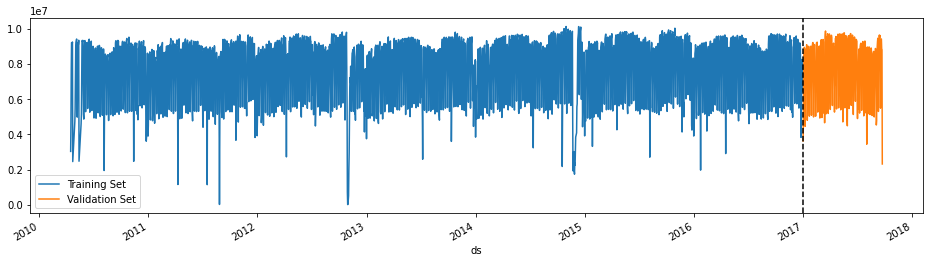

In [3]:
# Splits the data into training and validation
df_tot = df_tot.rename(columns={'datetime':'ds', 'traffic':'y'})

df_train = df_tot[df_tot.ds < '2017-01-01']
df_val = df_tot[~(df_tot.ds < '2017-01-01')]

# Plot
fig, ax = plt.subplots(figsize=(16, 4))
df_train.set_index('ds').plot(ax=ax)
df_val.set_index('ds').plot(ax=ax)
ax.axvline('2017-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Validation Set'])
plt.show()

In [4]:
# Fitting Prophet model on training data (years: 2010 ~ 2017)
m = Prophet(seasonality_mode='multiplicative')
m.fit(df_train)

18:28:11 - cmdstanpy - INFO - Chain [1] start processing
18:28:11 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# Predicting future values (year: >2017)
future = m.make_future_dataframe(periods=len(df_val), include_history=False)
forecast = m.predict(future)

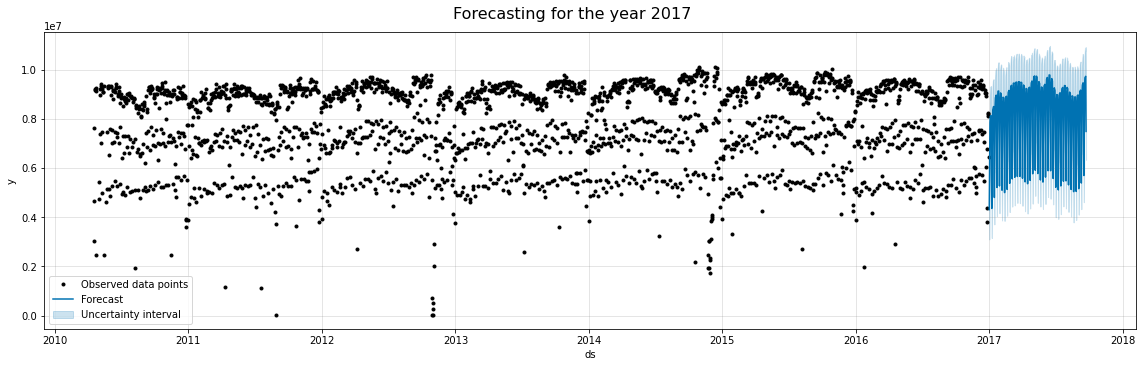

In [6]:
m.plot(forecast, figsize=(16, 5), include_legend=True).suptitle('Forecasting for the year 2017', size=16, y=1.01);

The figure above presents the forecasting results for the 2017 using the Prophet approach.

Let's take a look in the time series components extracted by the Prophet.

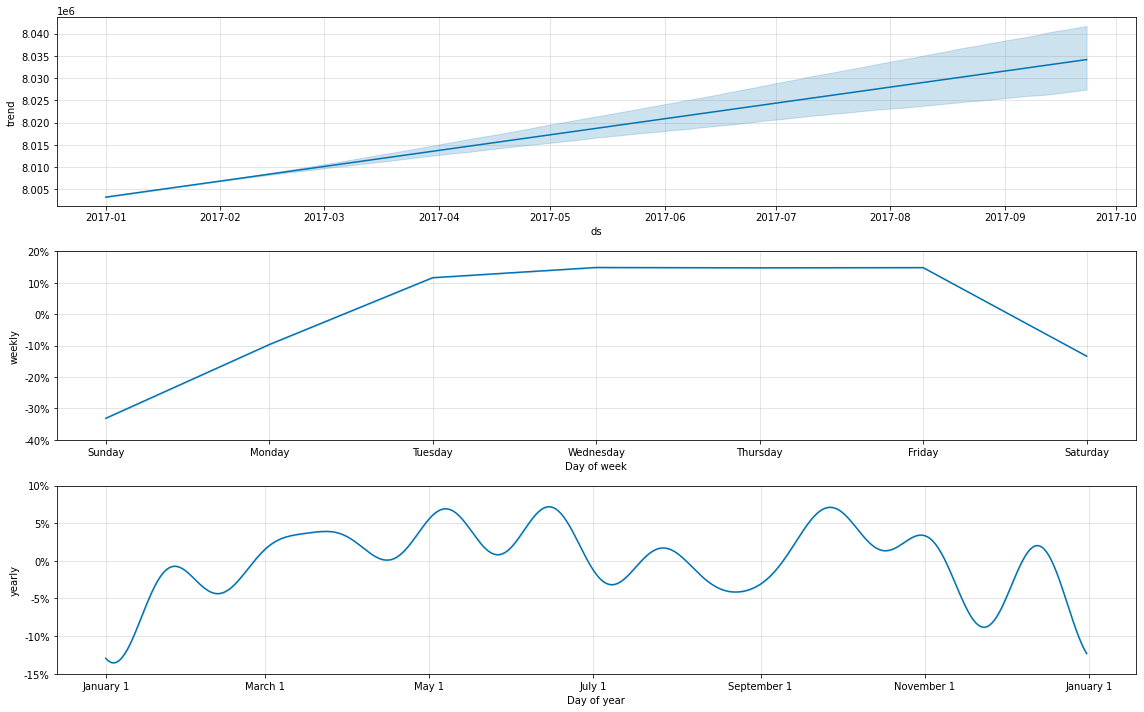

In [7]:
m.plot_components(forecast, figsize=(16, 10));

As we can see in the components, the time series has almost no trend, because it is increasing very slowly. Also, 
it was able to capture the weekly seasonality which is very similar to what we saw in EDA.

#### Evaluating results

Let's see how well our predictions fits the real data.

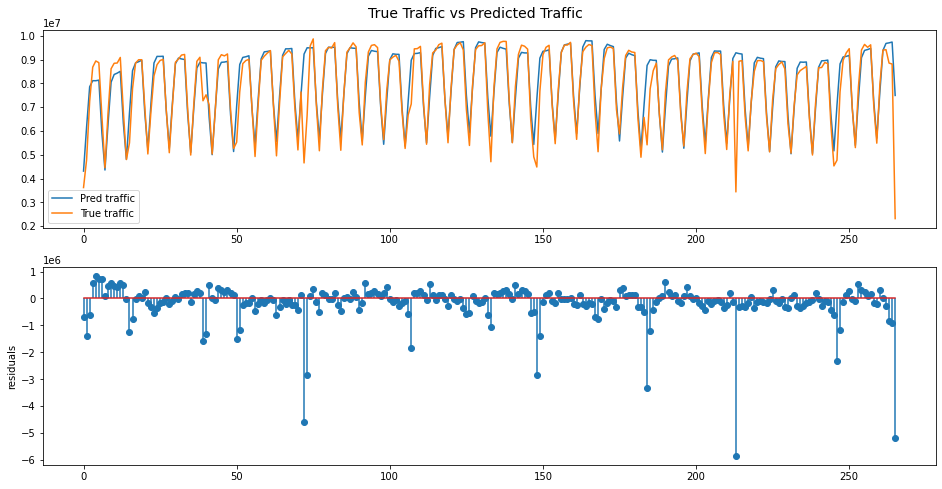

In [8]:
y_true = df_val.y.values
y_pred = forecast.yhat.values

def plot_true_pred_comparison(y_true, y_pred):
    fig, ax = plt.subplots(2, 1, figsize=(16, 8))
    ax[0].plot(np.vstack((y_pred, y_true)).transpose())
    ax[0].legend(['Pred traffic', 'True traffic'])

    ax[1].stem(range(len(y_true)), y_true-y_pred)
    ax[1].set_ylabel('residuals')
    plt.suptitle('True Traffic vs Predicted Traffic', y=0.92, size=14)
    plt.show()
    
plot_true_pred_comparison(y_true, y_pred)

We can see that the predictions has a good coverage of the data. However, looking at the residuals we see that there are some valleys that the model was not able to estimate. These cases are really challenging as they don't show a well-behaved pattern.

Below we calculate some useful metrics:

In [9]:
def compute_ts_metrics(y_true, y_pred):
    """
    Compute and print a set of metrics to evaluate the predicted values.
    """
    mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = metrics.mean_squared_error(y_true, y_pred, squared=False)

    print("Metrics")
    print("----------------")
    print("MAPE : %.4f" % (mape))
    print("MAE  : %.2f" % (mae))
    print("RMSE : %.2f" % (rmse))
    
compute_ts_metrics(y_true, y_pred)

Metrics
----------------
MAPE : 0.0645
MAE  : 371521.77
RMSE : 768501.76


The MAPE metric shows us that the forecast presents an percetual deviation of 6.45% in relation to the true data.

We can try to improve our results by adding holidays to the Prophet model. Our dataset is from the US, so Prophet already has a built-in set of US holidays that can be added to the model. Let's do that and see how it performs.

In [10]:
# Fitting model with US Holidays
m = Prophet(seasonality_mode='multiplicative')
m.add_country_holidays(country_name='US')
m.fit(df_train)

# Predicting future values
future = m.make_future_dataframe(periods=len(df_val), include_history=False)
forecast = m.predict(future)

# Evaluate
y_true = df_val.y.values
y_pred = forecast.yhat.values
compute_ts_metrics(y_true, y_pred)

18:28:14 - cmdstanpy - INFO - Chain [1] start processing
18:28:14 - cmdstanpy - INFO - Chain [1] done processing


Metrics
----------------
MAPE : 0.0556
MAE  : 315992.83
RMSE : 691704.98


Nice! the holidays addition improve our results. The MAPE metric was significantly reduced from **0.0645** to **0.0556**.

### 2.1.2. Forecast by stations and lines <a class="anchor" id="prophet-2"></a>

Now let's try to predict the traffic of some specific station/line. I chose two non-stationary time series in the EDA that look more challenging than the total traffic.

Below we have a method that do all the steps above. It split, train, predict and plot the results for us.

In [11]:
def train_and_predict_prophet(df, title):
    
    # Split dataset
    cut_date = '2017-01-01'
    df = df.rename(columns={'datetime':'ds', 'traffic':'y'})
    df = df.groupby('ds').y.sum().reset_index()
    df_train = df[df.ds < cut_date]
    df_val = df[~(df.ds < cut_date)]
    
    # Training
    m = Prophet(seasonality_mode='multiplicative')
    m.add_country_holidays(country_name='US')
    m.fit(df_train)

    # Forecasting
    future = m.make_future_dataframe(periods=len(df_val), include_history=True)
    forecast = m.predict(future)
    
    # Plot All time series
    fig = m.plot(forecast, figsize=(18, 4))
    ax = fig.gca().set_title(title, size=22)
    plt.plot(df_val.ds, df_val.y, color='C1')
    plt.show()
    
    # Plot only the future values
    forecast = forecast[forecast.ds>=cut_date]
    x = forecast.ds
    y_true = df_val.y.values
    y_pred = forecast.yhat.values
    
    plt.figure(figsize=(18, 4))
    plt.plot(y_pred, color='C0')
    plt.plot(y_true, color='C1')
    plt.legend(['Pred Traffic', 'True Traffic'])
    plt.show()
    
    # Compute metrics
    compute_ts_metrics(y_pred, y_true)

Forecasting the station traffic

18:28:17 - cmdstanpy - INFO - Chain [1] start processing
18:28:17 - cmdstanpy - INFO - Chain [1] done processing


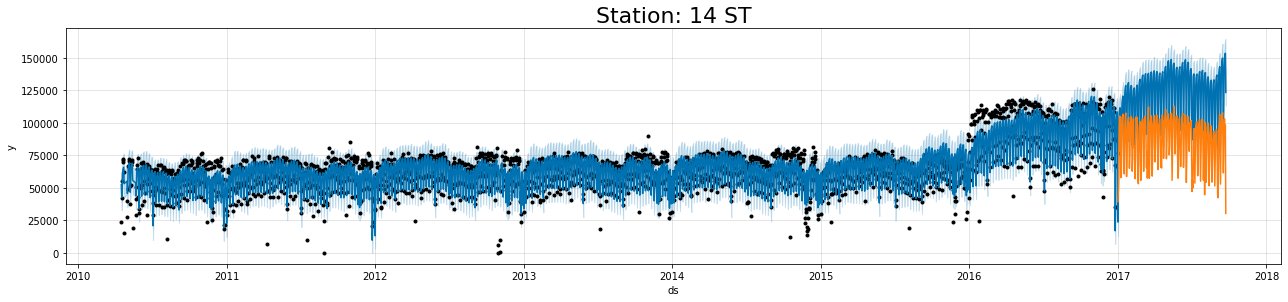

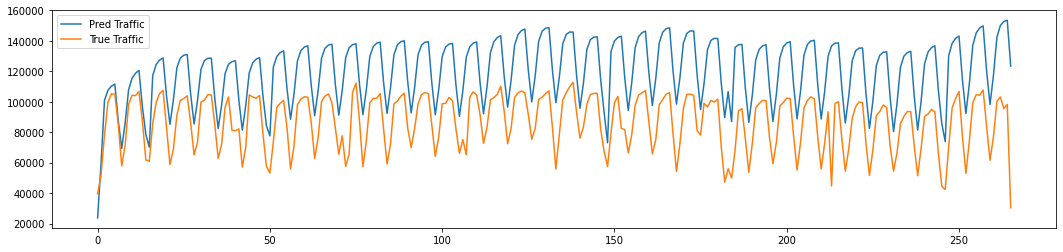

Metrics
----------------
MAPE : 0.2800
MAE  : 33378.19
RMSE : 35256.74


In [12]:
# Station
train_and_predict_prophet(df_st[df_st['station']==STATION_TEST], title=f'Station: {STATION_TEST}')

This case is challenging because the station had a sudden increase in traffic in 2016 and a downward trend after that. But the model estimated that traffic would continue to increase in 2017.

Forecasting the line traffic

18:28:22 - cmdstanpy - INFO - Chain [1] start processing
18:28:22 - cmdstanpy - INFO - Chain [1] done processing


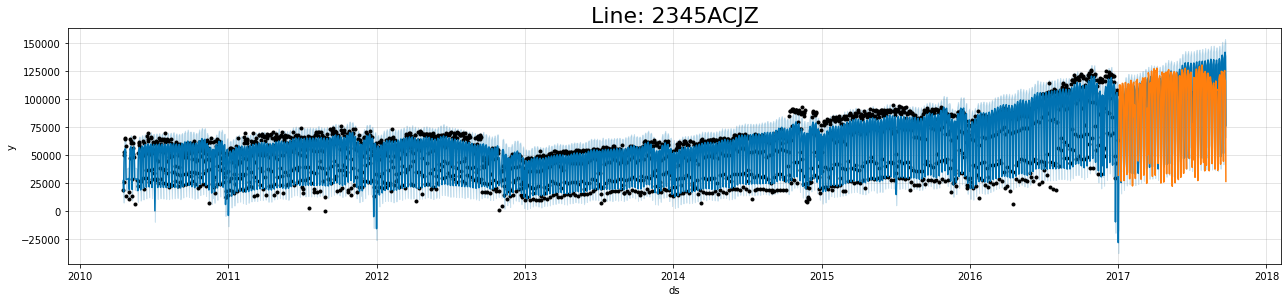

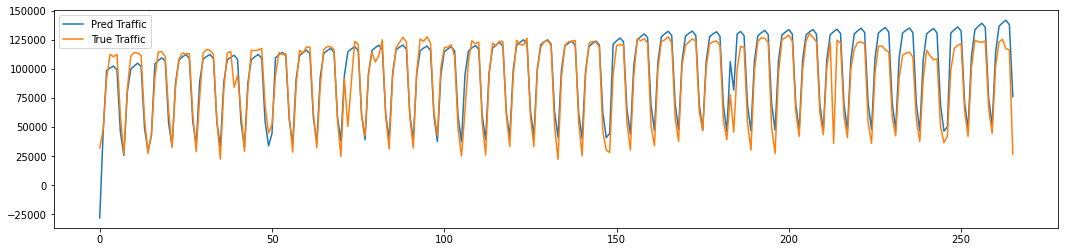

Metrics
----------------
MAPE : 0.1157
MAE  : 9316.98
RMSE : 13616.30


In [13]:
# Line
train_and_predict_prophet(df_ln[df_ln['linename']==LINE_TEST], title=f'Line: {LINE_TEST}')

The Prophet did a better job in this time series. However, it presents certain deviation in the last months.

## 2.2. XGBoost <a class="anchor" id="xgboost"></a>

Now it's time to try the XGBoost and see how it performs.

### 2.2.1 Total traffic forecast <a class="anchor" id="xgboost-1"></a>

To use the XGBoost we need to handle the forecasting as a Regression problem. So, first let's create some time features to be used by our model.

In [14]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['week'] = df.index.week
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

train = create_features(df_train.set_index('ds'))
val = create_features(df_val.set_index('ds'))

train.head()

,y,dayofweek,dayofyear,week,month,year
ds,,,,,,
2010-04-17,3030711.0,5,107,15,4,2010
2010-04-18,4655330.0,6,108,15,4,2010
2010-04-19,7629846.0,0,109,16,4,2010
2010-04-20,9207197.0,1,110,16,4,2010
2010-04-21,9184459.0,2,111,16,4,2010


We need to separate the features and target before training the model.

In [15]:
FEATURES = ['dayofweek', 'dayofyear', 'week', 'month', 'year']
TARGET = 'y'

X_train, y_train = train[FEATURES], train[TARGET]

X_val, y_val = val[FEATURES], val[TARGET]

Training the XGBoost Regressor

In [16]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=100);

[0]	validation_0-rmse:7922119.15726	validation_1-rmse:7945329.50207
[100]	validation_0-rmse:3009309.29608	validation_1-rmse:2974610.08996
[200]	validation_0-rmse:1286952.39756	validation_1-rmse:1225586.88508
[300]	validation_0-rmse:722438.70051	validation_1-rmse:747551.99557
[400]	validation_0-rmse:558733.77258	validation_1-rmse:670831.23816
[500]	validation_0-rmse:467123.83694	validation_1-rmse:661122.01799
[590]	validation_0-rmse:423380.39055	validation_1-rmse:661013.70472


The XGBoost allows us to see the importance of each feature, so let's plot it.

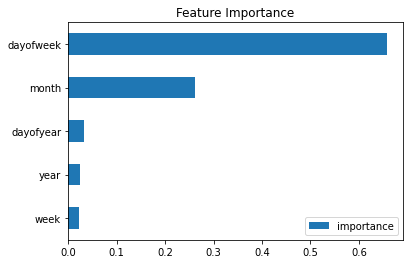

In [17]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=['importance']
)

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

#### Evaluating results

Let's see how well our predictions fits the real data.

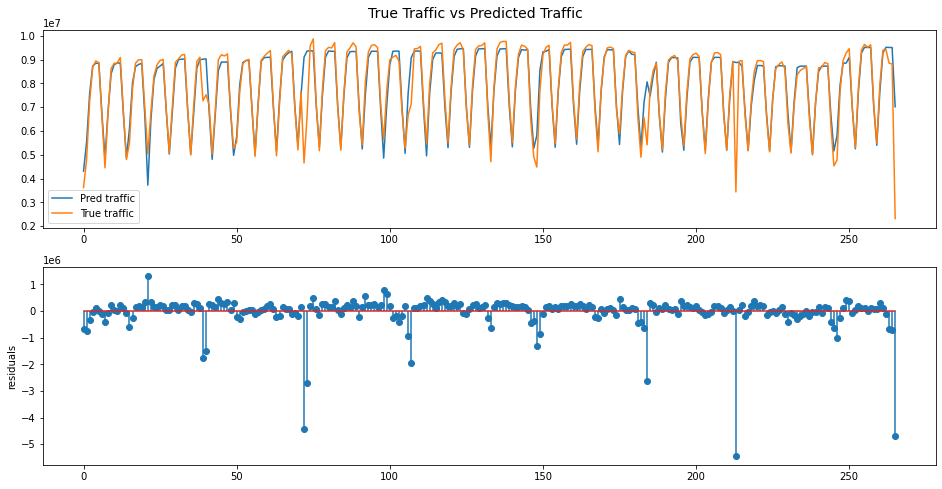

In [18]:
val['pred'] = reg.predict(X_val)

y_true = val.y.values
y_pred = val.pred.values

plot_true_pred_comparison(y_true, y_pred)

In [19]:
compute_ts_metrics(y_true, y_pred)

Metrics
----------------
MAPE : 0.0525
MAE  : 301313.99
RMSE : 660703.64


XGBoost performed very well in this time series. It also achieved a slightly lower MAPE metric than the Prophet.

### 2.2.2. Forecasting by stations and lines <a class="anchor" id="xgboost-2"></a>

Do the same steps as with Prophet, but this time using the XGBoost Regressor model.

In [20]:
def train_and_predict_xgboost(df, title):
    
    # Split dataset
    cut_date = '2017-01-01'
    df = df.rename(columns={'datetime':'ds', 'traffic':'y'})
    df = df.groupby('ds').y.sum().reset_index()
    df_train = df[df.ds < cut_date]
    df_val = df[~(df.ds < cut_date)]

    # Create features
    train = create_features(df_train.set_index('ds'))
    val = create_features(df_val.set_index('ds'))
    
    # Split features and targets
    X_train, y_train = train[FEATURES], train[TARGET]
    X_val, y_val = val[FEATURES], val[TARGET]

    # Training
    reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=500)

    # Forecasting
    train['pred'] = reg.predict(X_train)
    val['pred'] = reg.predict(X_val)

    y_pred = val['pred']
    y_true = val['y']
    
    # Plot results
    fig, ax = plt.subplots(2, 1, figsize=(18, 9))
    ax[0].scatter(train.index, train.y, c='k', marker='.')
    ax[0].plot(train.pred, c='C0')
    ax[0].plot(y_pred, c='C0')
    ax[0].plot(y_true, c='C1')
    ax[1].plot(y_pred)
    ax[1].plot(y_true)
    ax[1].legend(['Pred traffic', 'True traffic'])
    plt.show()
    
    # Compute metrics
    compute_ts_metrics(y_pred, y_true)

[0]	validation_0-rmse:67049.30423	validation_1-rmse:87455.50039
[500]	validation_0-rmse:4962.58101	validation_1-rmse:10756.90903
[999]	validation_0-rmse:3645.83863	validation_1-rmse:11005.14012


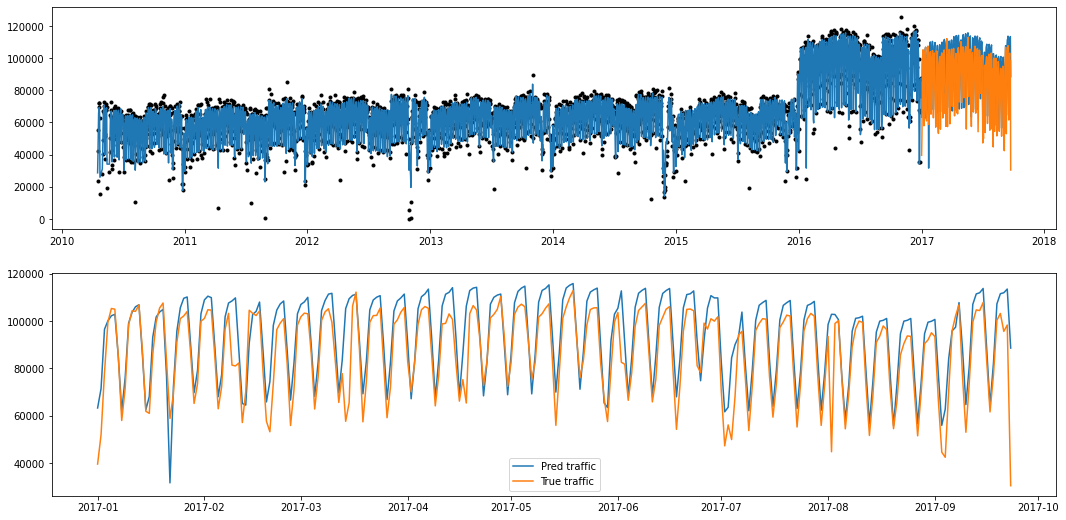

Metrics
----------------
MAPE : 0.0878
MAE  : 7827.22
RMSE : 11005.14


In [21]:
# Station
train_and_predict_xgboost(df_st[df_st['station']==STATION_TEST], title=f'Station: {STATION_TEST}')

The XGBoost did a great job here. It was able to capture the downward trend in the time series which Prophet wasn't.

[0]	validation_0-rmse:59841.58143	validation_1-rmse:97138.58118
[500]	validation_0-rmse:5102.50544	validation_1-rmse:24159.47793
[999]	validation_0-rmse:3825.11685	validation_1-rmse:23609.88259


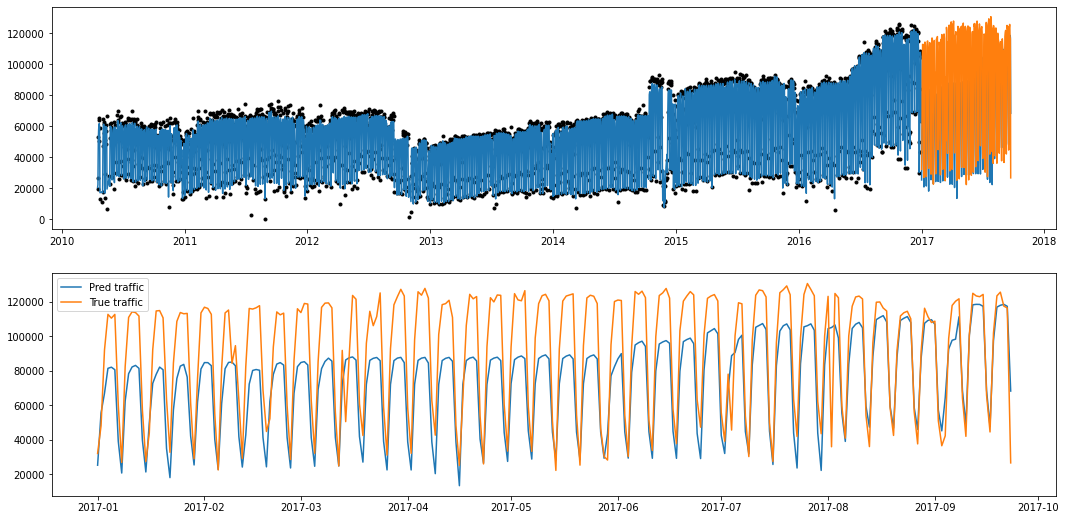

Metrics
----------------
MAPE : 0.2922
MAE  : 20160.38
RMSE : 23609.88


In [22]:
# Station
train_and_predict_xgboost(df_ln[df_ln['linename']==LINE_TEST], title=f'Line: {LINE_TEST}')

XGBoost performed bad for this one. It wasn't able to capture the magnitude of the seasonality here and it predicted values below the actual values.

# 3. Summary of results <a class="anchor" id="summary"></a>

Comparison between methods:

| Method  | Time Series     | MAPE   | MAE       | RMSE      | Stationary |
| ------- | --------------- | ------ | --------- | --------- | ---------- |
| Prophet | Total Traffic   | 0.0556 | 315992.83 | 691704.98 | Yes        |
| XGBoost | Total Traffic   | 0.0525 | 301313.99 | 660703.64 | Yes        |
| Prophet | Station '14 ST' | 0.2800 | 33378.19  | 35256.74  | No         |
| XGBoost | Station '14 ST' | 0.0878 | 7827.22   | 11005.14  | No         |
| Prophet | Line '2345ACJZ' | 0.1157 | 9316.98   | 13616.30  | No         |
| XGBoost | Line '2345ACJZ' | 0.2922 | 20160.38  | 23609.88  | No         |


The approaches presented a similar result in the Total Traffic Time Series. However, they presented opposite results considering the other cases.

I believe that for the stationary time series both solutions have a good predictive potencial and would be quite useful in practice. For non-stationary time series you need to pay extra attention to make sure it will work.